# **Advertising: Predicting who will click on the Ad**
## [Kaggle Advertising Challenge](https://www.kaggle.com/fayomi/advertising)

**Author - Danish Anis**

**Contact - danishanis10@hotmail.com**


#### This project is divided in 5 sections:

1. Introduction
    
    *1.1 Importing Libraries*
    
    *1.2 Useful Functions*

2. Loading Dataset

    *2.1 Visualizing Data*
    
3. Exploratory Data Analysis (EDA)

    *3.1 Describing Features*
    
    *3.2 Descriptive Figures*
    
        3.2.1 Distribution Plots
        
        3.2.2 Boxplots
        
        3.2.3 Cross-correlation Plot
        
        3.2.4 Distribution Plots With Respect To Our Target Feature
        
        3.2.5 Pair Plots With Respect To Our Target Feature
    
    *3.3 Feature Engineering*

        3.3.1 Skewed Features: Log Transform
        
        3.3.2 Removing Some Features
        
        3.3.3 Normalization Of Numerical Features
        
        3.3.4 Processing Categorical Feature: One Hot-Encoding

4. Model Selection

    *4.1 Data Preparation: Training and Testing Sets*

    *4.2 Model Selection: Logistic Regression*
    
        4.2.1 Logistic Regression
        
        4.2.2 Confusion Matrix, Precision, Recall, F1-Score

5. Actionable Recommendations

##**1. Introduction**

The task is to predict who will most likely click on the ad. Let's consider that we are working for a marketing company. Firstly, we have to understand what constitutes a profit and a loss. 

Let's assume that you have a marketing campaign for which we spend **1000USD per potential customer**. For each **customer that we target** with our ad campaign **and** that **clicks on the ad**, we get an **overall profit of 100USD**. However, if we target a **customer that ends up not clicking** on the ad, we incur a **net loss of 1050USD**. Therefore we can conclude that for each **customer that was not targeted** by the campaign **and** who **clicks on the ad**, we get an **overall profit of 1100USD**. Unfortunately, we have no information about the advertized product; this information could have guided us through our understanding of the user behavior.


### 1.1 Importing Libraries

In [0]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline 

# Defining categorical, numerical, and datetime variables that we will use later
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male", "log_age"]
datetime_vars = "Timestamp"
target = "Clicked on Ad"

### 1.2 Useful Functions

In [0]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)

## **2. Exploring the Data**

### 2.1 Visualizing data:



In [59]:
# Loading the data
advertising = pd.read_csv("advertising_data.csv")
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


In [60]:
advertising.shape

(1018, 10)

In [61]:
unique_ad_topics = advertising['Ad Topic Line'].unique().shape[0]
repeated_ad_topics = advertising.shape[0] - unique_ad_topics
print("Number of Ad topic lines repeated:", repeated_ad_topics)

Number of Ad topic lines repeated: 18


Looking at summary statistics of our data, including any null values

In [62]:
advertising.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               4
dtype: int64

So we know that the column 'Clicked on Ad' has 4 null values. These cannot be ignored as the missing values are in the target features. Lets analyze these rows with null values. 

In [63]:
rows_with_null = advertising[advertising.isna().any(axis=1)]
rows_with_null

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
131,67.36,37,73104.47,233.56,Future-proofed grid-enabled implementation,North Wesleychester,0,Jersey,2016-07-06 16:00,NaN
217,67.28,43,76246.96,155.80,Future-proofed coherent hardware,North Mercedes,1,Pakistan,2016-04-03 21:13,NaN
431,34.30,41,53167.68,160.74,Re-contextualized reciprocal interface,West Melaniefurt,1,Libyan Arab Jamahiriya,2016-05-16 14:50,NaN
722,46.89,48,72553.94,176.78,Polarized mission-critical structure,Chaseshire,1,Turkey,2016-07-17 13:22,NaN


Since there are only 4 rows with null values in the target variable, removing them will not have a significant impact on the overall prediction. So it is better if we remove them

In [0]:
advertising.dropna(inplace = True)

In [76]:
print("Dataset Shape:",advertising.shape)
advertising.isnull().sum()

Dataset Shape: (1014, 10)


Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [74]:
# Assessing if duplicated records are found in the training dataset
print("Number of duplicated records: ", advertising.duplicated().sum())

Number of duplicated records:  7


So we have 7 rows that are completly identical to the other rows

In [0]:
# Removing the duplicated rows from the dataset
advertising = advertising.drop_duplicates()

---------

## **3. Exploratory Data Analysis (EDA)**

### 3.1 Describing The Features

In [93]:
# Looking at the distribution of the target feature
click_rate = (advertising["Clicked on Ad"].value_counts() / advertising.shape[0])*100
print("If '1.0' means 'Clicked' & '0.0' means 'Not Clicked'\n")
print("% of times either of these events happened:\n",click_rate)

If '1.0' means 'Clicked' & '0.0' means 'Not Clicked'

% of times either of these events happened:
 1.0    50.248262
0.0    49.751738
Name: Clicked on Ad, dtype: float64


Therefore, this is a well balanced data set.


'Timestamp' feature is an object. If required to perform analysis on this, we won't be able to unless this column is transformed into datetime, a format that will allow us to perform calculations on it.

In [97]:
advertising["Timestamp"] = pd.to_datetime(advertising["Timestamp"])
advertising['Timestamp']

0      2016-03-27 00:53:00
1      2016-04-04 01:39:00
2      2016-03-13 20:35:00
3      2016-01-10 02:31:00
4      2016-06-03 03:36:00
               ...        
1013   2016-02-11 21:49:00
1014   2016-04-22 02:07:00
1015   2016-02-01 17:24:00
1016   2016-03-24 02:35:00
1017   2016-06-03 21:43:00
Name: Timestamp, Length: 1007, dtype: datetime64[ns]

In [100]:
# Extract Descriptive Statistics
advertising.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,64.952403,36.958292,54899.398868,179.386514,0.482622,0.502483
std,15.850441,31.729539,13458.555374,44.548765,0.499946,0.500242
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.270000,29.000000,46899.780000,138.490000,0.000000,0.000000
50%,68.100000,35.000000,56984.090000,182.200000,0.000000,1.000000
75%,78.535000,42.000000,65350.775000,218.550000,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


We can appreciate that our features do not seem to be skewed as the mean and the median are roughly similar. This suggests that we would not need to transform our data, at least based on their distribution. However we will investigate this assumption later by plotting our data.

However, we can observe something fishy with the age column where the minimum value is -25 years and one of the highest values include 999 years! Let's investigate!

In [145]:
print('Unique Ages in the Dataset: \n',(advertising['Age'].unique()),'\n')

Unique Ages in the Dataset: 
 [ 35  31  26  29  23  33  48  30  20  49  37  24  41  36  40  52  28  34
  22  57  53  39  46  32  25  43  45  50  47  27  42  38  54  21  60  55
  44  58  56  51 -25  19  59 999 103  61   8] 



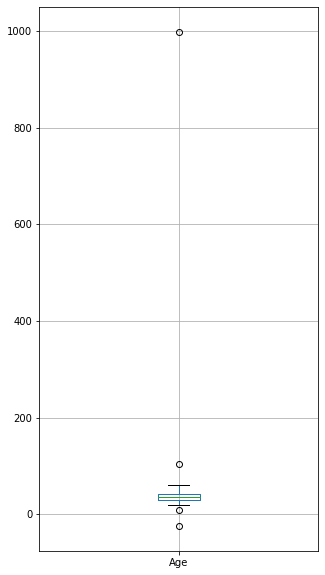

In [142]:
#A boxplot may help us visualize how unrealistic/extreme the outliers are
boxplot = advertising.boxplot(column =['Age'], figsize=(5,10))

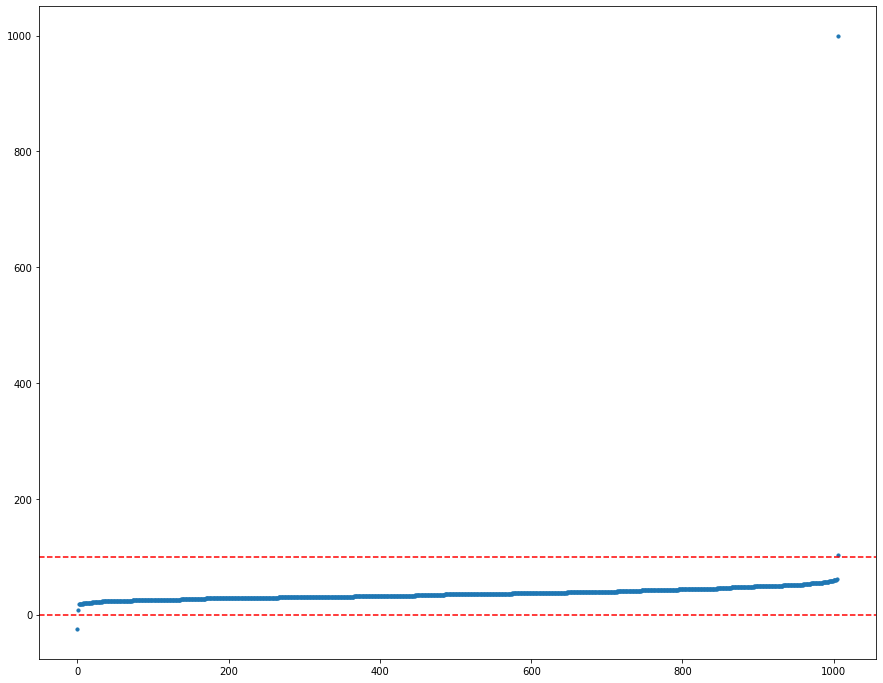

In [113]:
# Sorting ages in order
# Plotting sorted age against their index
sorted_age = sorted(advertising['Age'])
idx = []
for i in range(len(sorted_age)):
    idx.append(i) #list of all ages from 0 to 1000+ in the dataset
x = idx
y = sorted_age


plt.figure(figsize=(15,12))
plt.scatter(x, y, s=10)

#horizontal red lines added to serve as reference points for the extreme values
## nothing below 0 or over 100
plt.axhline(y=0, linestyle='--', color='r')
plt.axhline(y=100, linestyle='--', color='r')

Looking at this graph, we can say that we have atleast 4 rows with extreme age values that can be removed.

In [148]:
advertising[(advertising['Age'] > 100) | (advertising['Age'] < 18)]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
294,56.01,-25,46339.25,127.26,Re-engineered real-time success,Garciamouth,0,Tonga,2016-07-05 18:59:00,1.0
495,50.60,999,34191.13,129.88,Realigned reciprocal framework,New Daniellefort,1,United States of America,2016-05-03 12:57:00,1.0
604,57.20,103,57739.03,110.66,Innovative maximized groupware,East Heatherside,0,New Zealand,2016-03-19 11:09:00,1.0
823,43.16,8,25371.52,156.11,Implemented didactic support,Williamsport,1,Marshall Islands,2016-07-06 03:40:00,1.0


In [0]:
# Removing the extreme age values
##we are basically just keeping values that are above 18 and below 100 in the main dataset
advertising = advertising[(advertising['Age'] >= 18) & (advertising['Age'] < 100)]

In [152]:
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0


Another interesting analysis one can do is comparing time spent on the website vs. daily internet usage. The latter should realistically be either greater than or equal to the former!

Let's check out if the 'Daily TIme Spend on Site' is actually smaller or equal to the Daily Internet Usage'

In [155]:
# Let's check out if the 'Daily Time Spend on Site' 
# is actually smaller or equal to the Daily Internet Usage'

#We add a delta column that gives the difference between the two
advertising['delta'] = advertising['Daily Internet Usage'] - advertising['Daily Time Spent on Site']

#Checking how many rows don't follow this (Must be clarified with the data team)
sum(advertising['delta'] < 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


3

In [0]:
# Removing rows with a delta smaller than zero because that is just unrealistic
advertising = advertising[advertising['delta'] >= 0]

# Removing the delta column as it is not really needed anymore
advertising = advertising.drop('delta', axis=1)

### 3.2 Descriptive Figures

#### 3.2.1 Distribution Plots

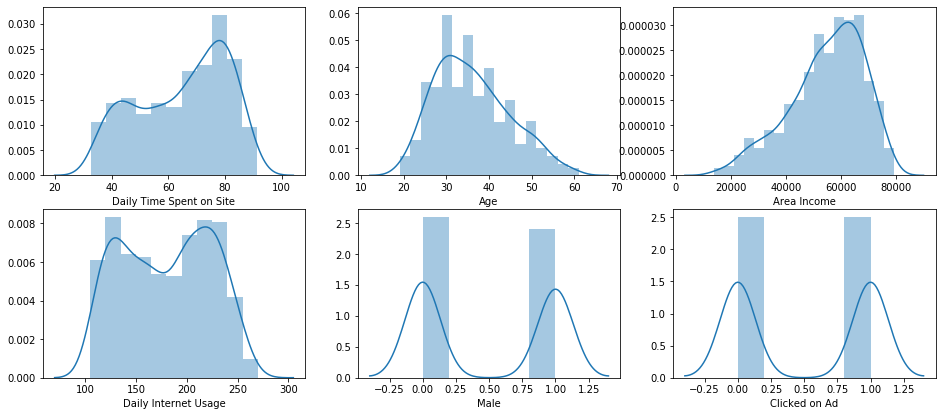

In [160]:
# Distribution plots for numerical features only
num_vars = advertising.select_dtypes(exclude=['object', 'datetime64']).columns

# Creating distribution plots
creating_distplot((16,18), advertising, num_vars)

From the overall distributions, we can observe interesting bimodal distributions for the "daily internet usage", and "daily time spent on site" which could suggest the presence of more than one group. Furthermore, the age and "area income" are little bit skewed which could potentially bias our model later on. In a subsequent step, we will apply log transformation at least on the age feature. 

#### 3.2.2 Boxplots

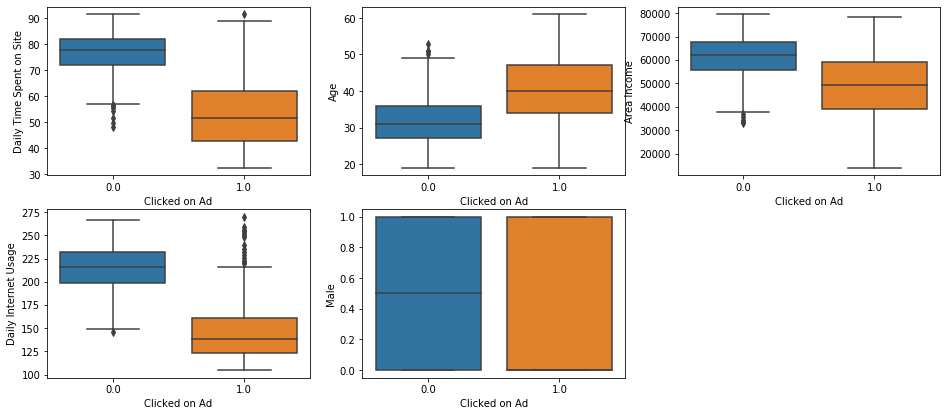

In [163]:
# Generating boxplots with respect to our target feature
creating_boxplots((16,18), target, num_vars, advertising)

Both boxplots on "Daily time spent on site" and "Daily internet usage" show a significant difference between the two groups, namely the people who clicked on the ad vs. the people who did not. Furthermore, we can observe a potential trend between these two groups  with age and area income respectively. 

#### 3.2.3 Cross-correlation Plot

                          Daily Time Spent on Site  ...  Clicked on Ad
Daily Time Spent on Site                  1.000000  ...      -0.748117
Age                                      -0.331513  ...       0.492531
Area Income                               0.310954  ...      -0.476255
Daily Internet Usage                      0.518658  ...      -0.786539
Male                                     -0.018951  ...      -0.038027
Clicked on Ad                            -0.748117  ...       1.000000

[6 rows x 6 columns]


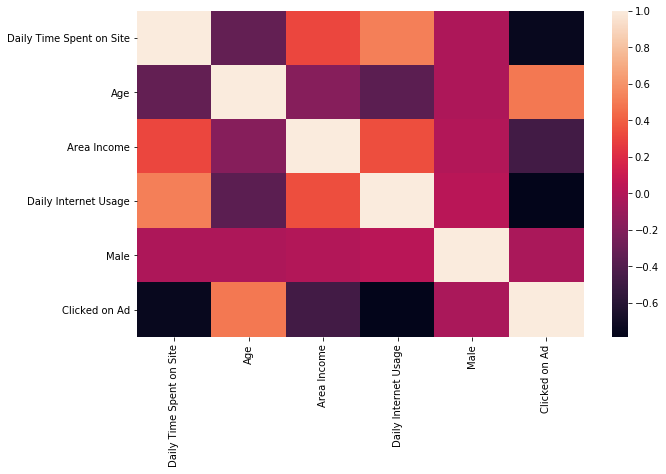

In [165]:
# Cross-correlation between the different features
## Also seen is how well independent features correlate with the target variable
crossCorrelation(advertising)

The cross-correlation revealed interesting potential relationship between our target feature and all the features except sex. Now, we would need to keep these relationship in mind since there seems to be some collinearity between the explanatory features as well.

#### 3.2.4 Distribution Plots With Respect To Our Target Feature

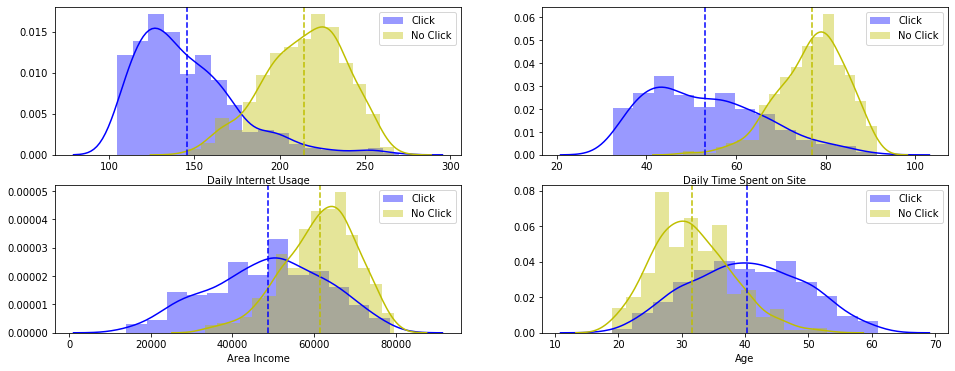

In [168]:
# Subsetting by clicks
click_yes = advertising["Clicked on Ad"] == 1
click_no = advertising["Clicked on Ad"] == 0

# Creating the plots
features = ["Daily Internet Usage", "Daily Time Spent on Site", "Area Income", "Age"]
labels = ["Click", "No Click"]

def creating_plots(features, labels):
    plt.figure(figsize=(16,6))
    for feature in features:
        plt.subplot(2, 2, features.index(feature)+1)
        sns.distplot(advertising[feature][click_yes], label=labels[0], color="b")
        sns.distplot(advertising[feature][click_no], label=labels[1], color="y")
        plt.axvline(advertising[feature][click_yes].mean(), linestyle = '--', color="b")
        plt.axvline(advertising[feature][click_no].mean(), linestyle = '--', color="y")
        plt.legend()

creating_plots(features, labels)

Regarding the categorical variables, we have almost all different cities, and we do not observe a huge amount of people within the same city, so we can guess that this feature has probably no predictive power. 
However, we have less diversity when it comes down to the different countries. Therefore we will take a look at the distribution of our sample with regards to the feature "Country".

In [169]:
table_country = pd.crosstab(index=advertising["Country"],     
                      columns="count")  
table_country.sort_values(["count"], ascending=False).head(10)

col_0,count
Country,
France,9
Czech Republic,9
Afghanistan,8
Australia,8
Turkey,8
South Africa,8
Senegal,8
Peru,8
Micronesia,8


In [170]:
table_clicked_country = pd.crosstab(advertising["Country"],
                                    advertising["Clicked on Ad"], rownames=['Country'],
                                    colnames=["Clicked On Ad"])
table_clicked_country.sort_values(1, 0, ascending=False).head(10)

Clicked On Ad,0.0,1.0
Country,,
Australia,1,7
Turkey,1,7
Ethiopia,0,7
Liberia,2,6
South Africa,2,6
Liechtenstein,0,6
Senegal,3,5
Peru,3,5
Mayotte,1,5


We can see that the users are fairly spread out acroos the globe; the the maximum users from one country reaches only 9, and that is for 237 different countries to consider. Therefore it makes it not very interesting to look at the city distribution.


the mean is:  4.22
the standard deviation is:  1.84


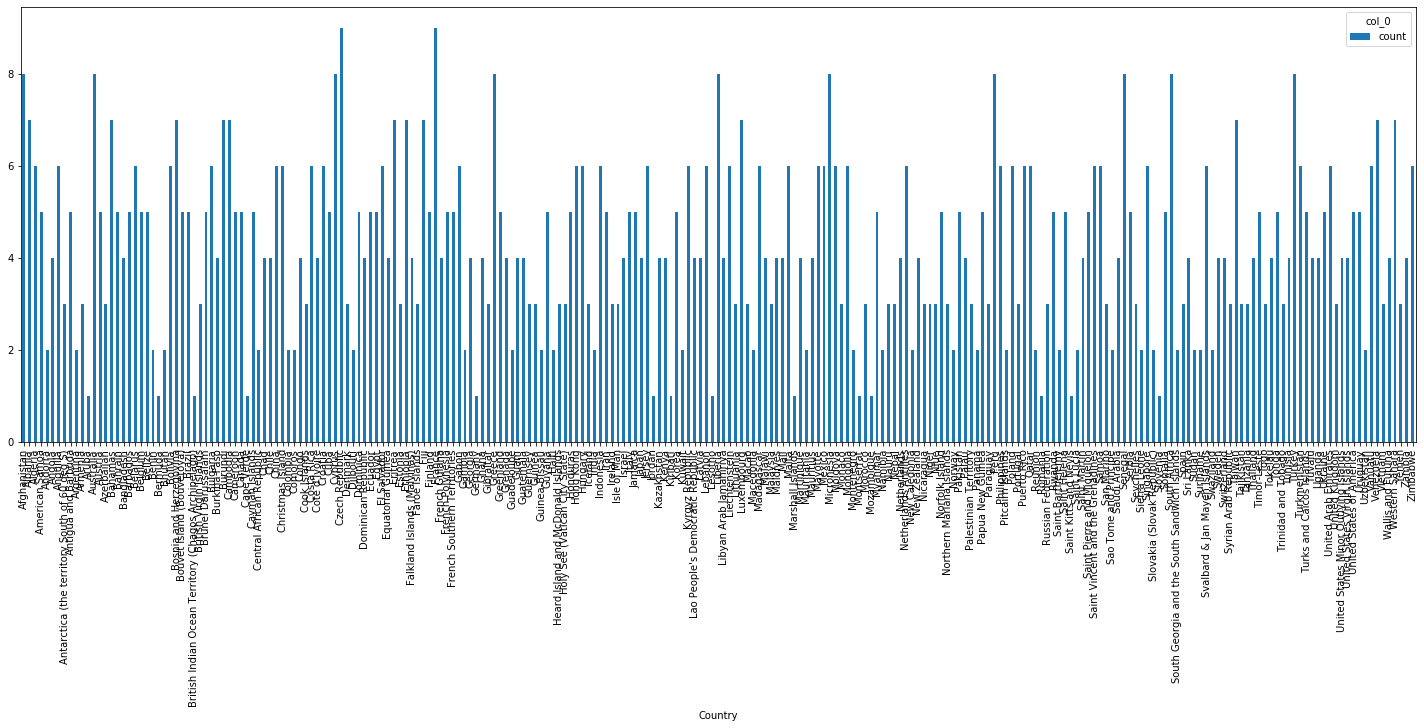

In [171]:
    table_country.plot.bar(figsize=(25,8))
    print("the mean is: ", round(np.mean(table_country["count"]),2))
    print("the standard deviation is: ", round(table_country["count"].std(),2))

#### 3.2.5 Pair Plots With Respect To Our Target Feature

<Figure size 432x288 with 0 Axes>

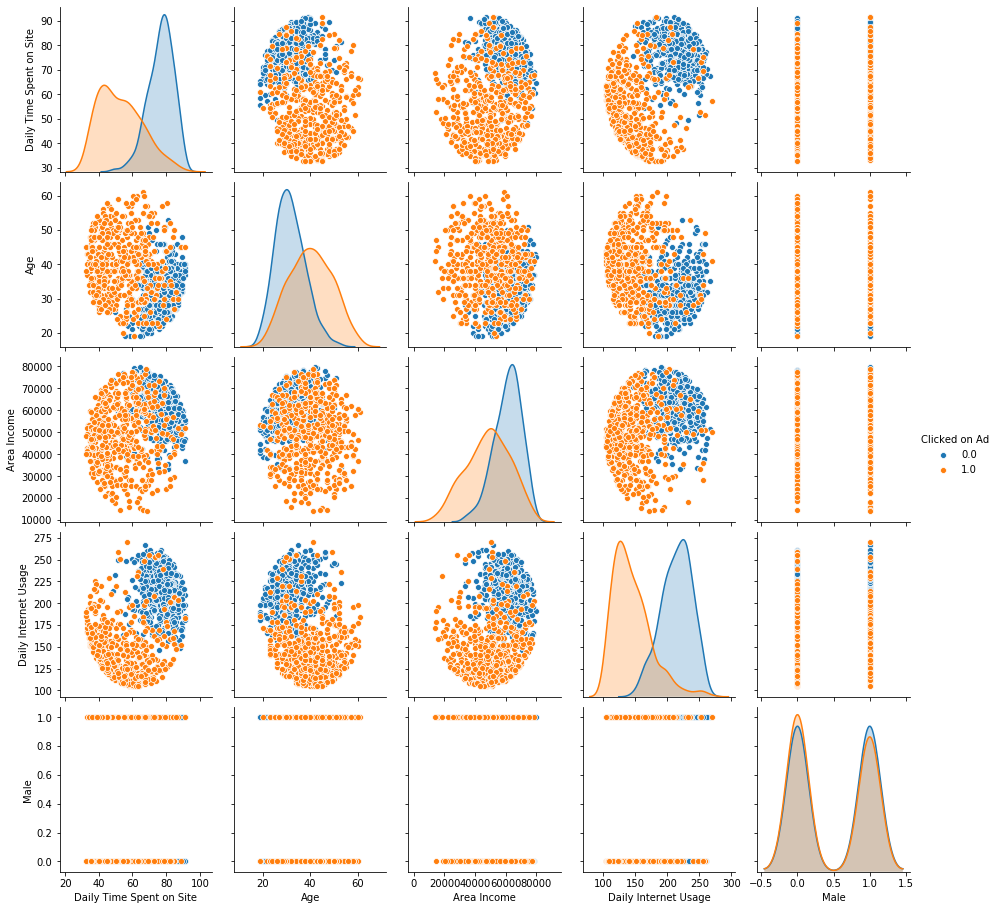

In [172]:
plt.figure()
sns.pairplot(data=advertising[num_vars],
             hue="Clicked on Ad",
             dropna=True)


### 3.3 Feature Engineering

#### 3.3.1 Skewed Features: Log Transform
Before performing machine learning, we will transform some features to avoid introducing some bias due to the overall distribution of the latter. As mentioned previously, we have some skewed distributions and they can make our models underperformed. To potentially solve this issue, we will apply a logarithmic transformation to reduce the effect of outliers and reduce the distribution's range.

From our previous EDA, we observe that "Age" was right skewed; therefore this transformation will be applied to this feature.


In [0]:
advertising["log_age"] = np.log(advertising["Age"])

#### 3.3.2 Removing Some Features

For the time being, we will remove some features that would need a special approach like Natural Language Processing, and time-related analysis to keep our model simple. Furthermore, we will not be considering the "City" feature because of its lack of specificity as stated earlier.

In [0]:
df = advertising.drop(["Ad Topic Line", "Timestamp", "City"], axis=1)


#### 3.3.3 Normalization Of Numerical Features

In [175]:
# Defining categorical, numerical, and datetime variables that we will use later
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male", "log_age"]
datetime_vars = "Timestamp"
target = "Clicked on Ad"

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

# Applying the MinMax transformation of the numerical variables
data = pd.DataFrame(data = df)
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])

# Show an example of a record with scaling applied
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country,Clicked on Ad,log_age
0,0.617882,35,0.730472,0.916031,0.0,Tunisia,0.0,0.523740
1,0.809621,31,0.831375,0.538746,1.0,Nauru,0.0,0.419696
2,0.626721,26,0.699200,0.797433,0.0,San Marino,0.0,0.268903
3,0.706272,29,0.623160,0.854280,1.0,Italy,0.0,0.362521
4,0.608023,35,0.914568,0.731323,0.0,Iceland,0.0,0.523740


#### 3.3.4 Processing Categorical Feature: One Hot-Encoding

In [0]:
# First, here is a one-hot encoding function to properly encode the categorical features for machine learning algorithm. 
# This function is fed with the entire dataset
final_data = pd.get_dummies(data)

## **4. Model Selection**

In this section, we will test various algorithms with our problem at hand to choose the best one in order to tune the model to its best parameters. In order to assess the different algorithms, we will use two metrics:

    - F1-Score
    
    - Time
    

### 4.1 Data Preparation: Training and Testing Sets

In [0]:
# Creating training and test set 
X, y = final_data.drop([target, "Age"],1).values, final_data[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y)



In [180]:
# Just as a sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 242)
(800,)
(200, 242)
(200,)


### 4.2 Model Selection: Logistic Regression


#### 4.2.1 Logistic Regression

First, we will perform a general gridsearch on the penalizing parameter of the L2-Regularization. We will use this search as a guideline for a more focus search in the next step.

In [182]:
from sklearn.linear_model import LogisticRegression


parameters = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]} #Regularization / Penalty value range

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Optimized Model
------
Final accuracy score on the testing data: 0.9600
Final F-score on the testing data: 0.9600
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


**We can see a testing accuracy score of 96% with the logistic regression model**

C is the inverse of the regularization term. Since we get **C = 1**, we know that we must investigate for an output penalty value of +/- 1 to get the most accurate result. However, this will change in the next cell



The previous step highlighted a value of 10 for the C parameter used in the L2-Regularization. We will now perform another search with a much narrower search in order to identify the best parameter.

In [183]:
from sklearn.linear_model import LogisticRegression


parameters = {"C": [5.2, 5.4, 5.6, 5.8, 6, 6.2, 6.4, 6.6, 6.8, 7, 9, 9.5, 10 , 10.5, 11]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.9900
Final F-score on the testing data: 0.9944
LogisticRegression(C=5.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


From the logisitic regression, with a model including most of our features, our best result on the training set are:

   **1. Accuracy of 99%**

   **2. F-score of 99.29%**
    
with L2-Regularization with C=5.8.

Accuracy is not always the best metric for all business problems. Let's look at other metrics such as the precision and recall

#### 4.2.2 Confusion Matrix, Precision, Recall, F1-Score

In [184]:
# Confusion matrix
confmat = confusion_matrix(y_train, best_predictions)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(y_train, best_predictions), 2))
print("Recall Score:", round(recall_score(y_train, best_predictions), 2))

The Confusion matrix:
 [[399   1]
 [  7 393]]
Precision Score: 1.0
Recall Score: 0.98


Because of our business problem, we want to focus on **lowering the false positive** since they are costing the company money when we spend money on a client that does not click on the ad. It is worth noting that considering the amount of profit the company is making following the campaign and the amount of money that is being made from false negatives, it is definitely worth it NOT to make any campaign and hoping for a maximum number of false negatives.
However, let's say that we can get more insights with our clients by identifying potential features that would support the idea if a client will click on our ad or not. Therefore, we want to have an interpretable model that has a **great precision to minimize the false positive** which incur loss of money, and a model that could have a **lower specificity (e.g., recall) which increases profit anyway**. Actually if it costs 1000USD to target a customer and brings an overall profit of 100USD, then we can estimate that the overall profit from someone clicking on the ad is 1100USD. Therefore, **it is definitely worth it to have false negative**.  

In [0]:
def summary_metrics(y, y_pred):
    confmat = confusion_matrix(y, y_pred)
    TP = confmat[0,0]
    FN = confmat[0,1]
    FP = confmat[1,0]
    TN = confmat[1,1]
 
    # Print the confusion matrix
    print("Confusion matrix:\n", confmat)
    print(FP, "cases of False Positives are causing the loss")
    print()
    
    # Print the Accuracy Score
    print("Accuracy:", round(accuracy_score(y, y_pred),2))

    # Print the Sensitivity/recall/true positive rate
    print("Sensitivity:", round(recall_score(y, y_pred),2))

    # Precision/positive predictive value
    print("Precision:", round(precision_score(y, y_pred),2))

    print("")
    print("DETAILS")
    
    # RETURN ON TP
    print("Profit from True Positives: $", round((float(TP)*100),2))
    
    # Return on FP
    print("Loss from False Positive: $", round((float(FP) * -1050),2))
    
    # Return on FN
    print("Gain from False Negative: $", round((float(FN) * 1100),2), 
          "(Assuming that the brand is well known and this is a possibility)")
    
    # Return on TN
    print("Profit from True Negative: $", round((float(TN) * 0), 2))
    
    # Return on investment
    investment_return = (TP * 100) + (FP * -1050) + (FN * 1100) + (TN * 0)
    print("Profit: $",round(float(investment_return),2))



In [215]:
# Getting the metrics from the confusion matrix with our best model on our training set
print(summary_metrics(y_train, best_predictions))

Confusion matrix:
 [[399   1]
 [  7 393]]
7 cases of False Positives are causing the loss

Accuracy: 0.99
Sensitivity: 0.98
Precision: 1.0

DETAILS
Profit from True Positives: $ 39900.0
Loss from False Positive: $ -7350.0
Gain from False Negative: $ 1100.0 (Assuming that the brand is well known and this is a possibility)
Profit from True Negative: $ 0.0
Profit: $ 33650.0
None


As mentioned previously, let's look at the probability distribution of our model to see if increasing the threshold could be beneficial to reduce the number of false positive, consequently reducing our loss.

Text(0, 0.5, 'Frequency')

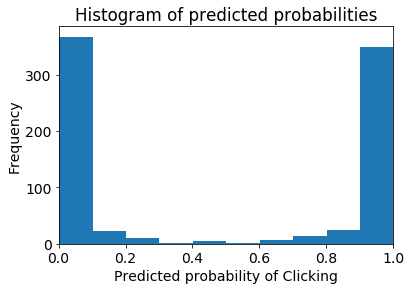

In [216]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]

plt.rcParams["font.size"]= 14
plt.hist(y_pred_prob, bins=10)
plt.xlim(0, 1)
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probability of Clicking")
plt.ylabel("Frequency")

By decreasing the threshold from 0.5 to 0.45, we may be able to reduce the number of false positives (e.g., 1), which result in a profit. However, it is important to highlight that decreasing the threshold, even if it helps reducing the amount of false positives, the prediction of still having false negative customers clicking on the ad is to be closely monitored. 

Let's look at our test set to see how we would perform with this model

In [217]:
test_predictions = best_clf.predict(X_test)
summary_metrics(y_test, test_predictions)

Confusion matrix:
 [[93  7]
 [ 4 96]]
4 cases of False Positives are causing the loss

Accuracy: 0.94
Sensitivity: 0.96
Precision: 0.93

DETAILS
Profit from True Positives: $ 9300.0
Loss from False Positive: $ -4200.0
Gain from False Negative: $ 7700.0 (Assuming that the brand is well known and this is a possibility)
Profit from True Negative: $ 0.0
Profit: $ 12800.0


In [0]:
test_predictions_prob = best_clf.predict_proba(X_test)[:,1]
y_testpred_class = np.where(test_predictions_prob<0.45, 0, 1)

In [219]:
summary_metrics(y_test, y_testpred_class)

Confusion matrix:
 [[93  7]
 [ 3 97]]
3 cases of False Positives are causing the loss

Accuracy: 0.95
Sensitivity: 0.97
Precision: 0.93

DETAILS
Profit from True Positives: $ 9300.0
Loss from False Positive: $ -3150.0
Gain from False Negative: $ 7700.0 (Assuming that the brand is well known and this is a possibility)
Profit from True Negative: $ 0.0
Profit: $ 13850.0


Considering our test set which included a sample size of 200 customers, we predict that our **overall profit would be $8800**. This prediction includes 

- **Profit of $9700 from true positives**

- **Profit of $3300 from false negatives**

- **Loss of $3300 from false positives**

Indeed false negatives are extremely rewarding considering this particular problem. 
On the other hand, we lose $3300 from mistakingly targeting customers that will not click on the ad. We have a loss that is the result of a misclassification, which in our case, is the equivalent of 2% of our overall prediction ( e.g., 4/200), and it corresponds to 4% false positive rate (e.g., 4/97). We can state that the results are excellent considering the marging of error and the predicted profit.


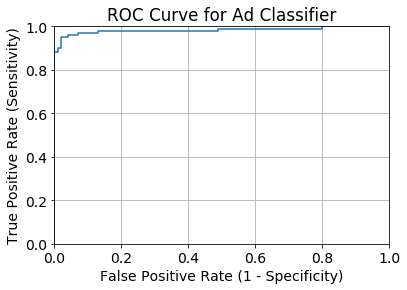

In [220]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve for Ad Classifier")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

Daily Time Spent on Site                                0.305220
Area Income                                             0.116308
Daily Internet Usage                                    0.318465
Male                                                    0.007172
log_age                                                 0.100762
Country_Afghanistan                                     0.000762
Country_Albania                                         0.000336
Country_Algeria                                         0.000800
Country_American Samoa                                  0.000201
Country_Andorra                                         0.001208
Country_Angola                                          0.000890
Country_Anguilla                                        0.000565
Country_Antarctica (the territory South of 60 deg S)    0.000306
Country_Antigua and Barbuda                             0.000331
Country_Argentina                                       0.000039
dtype: float64


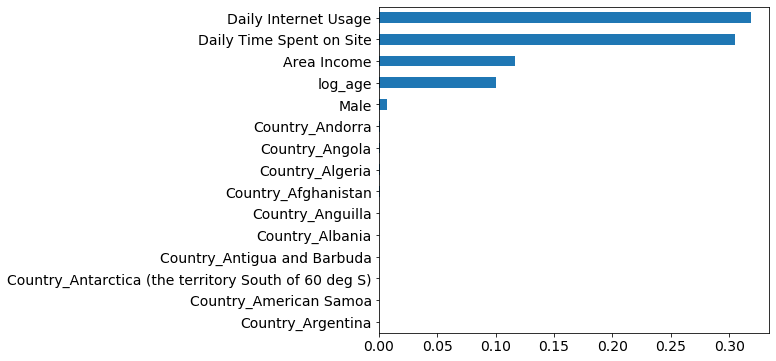

In [221]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Extracting feature importances from our model
feature_importances = pd.Series(model_rf.feature_importances_, index=final_data.drop([target, "Age"],1).columns)
sub_feature_importances = feature_importances[:15]
print(sub_feature_importances)

sub_feature_importances.sort_values(inplace=True)
sub_feature_importances.plot(kind='barh', figsize=(7,6))

#### **Decision Tree Classifier**

In [237]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# DT Object
clf = DecisionTreeClassifier(criterion="entropy", splitter = 'best', 
                             max_depth=3, min_samples_split = 2, min_samples_leaf = 1)

# Training DT classifier
clf = clf.fit(X_train, y_train)

#Predicting Values
y_dt_pred = clf.predict(X_test)

print("Decision Tree Metrics \n")
print("Accuracy: ", (metrics.accuracy_score(y_test, y_dt_pred))*100,"% \n")
summary_metrics(y_test, y_dt_pred)

Decision Tree Metrics 

Accuracy:  92.5 % 

Confusion matrix:
 [[92  8]
 [ 7 93]]
7 cases of False Positives are causing the loss

Accuracy: 0.92
Sensitivity: 0.93
Precision: 0.92

DETAILS
Profit from True Positives: $ 9200.0
Loss from False Positive: $ -7350.0
Gain from False Negative: $ 8800.0 (Assuming that the brand is well known and this is a possibility)
Profit from True Negative: $ 0.0
Profit: $ 10650.0


#### **Random Forest Classifier**

In [240]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

model_rf_pred = model_rf.predict(X_test)

print("Random Forest Metrics \n")
print("Accuracy: ", (metrics.accuracy_score(y_test, model_rf_pred))*100,"% \n")
summary_metrics(y_test, model_rf_pred)

Random Forest Metrics 

Accuracy:  93.5 % 

Confusion matrix:
 [[90 10]
 [ 3 97]]
3 cases of False Positives are causing the loss

Accuracy: 0.94
Sensitivity: 0.97
Precision: 0.91

DETAILS
Profit from True Positives: $ 9000.0
Loss from False Positive: $ -3150.0
Gain from False Negative: $ 11000.0 (Assuming that the brand is well known and this is a possibility)
Profit from True Negative: $ 0.0
Profit: $ 16850.0


## **5. Actionable Recommendations**
According to our model, we can identify potential clients by getting information about users on:

- Daily Time Spent on site
- Daily Internet Usage
- Age
- Area income

By getting this information, we can target new customers with our ad campaign to maximize the chance of a return on investment. We can speculate that the level of education could correlate with our finding since it was been previously reported that there is a correlation between the income and the level of education. 
From our exploratory data analysis and our machine learning results, our ***targeted population*** would be customers with:

- **Lower income**
- **Spending less time on the website**
- **Spending less time on the internet**
- **Who are older than our average sample (mean around 40 years old)**

Also by increasing our threshold from our model, we can minimize the false positives (e.g., minimizing loss) which optimizes our business approach.